In [137]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import re
import nltk
# nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger","parser", "ner"])

from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec, KeyedVectors

from src.preprocess import clean_text
from textwrap import wrap
import pickle

## Import pre-processed data

Write a function to import pre-processed data for modelling. Currently, just reading from a previously saved csv file.


In [96]:
data = pd.read_csv("data/dev_data.csv")
data['process_text'] = data['text'].apply(lambda x: clean_text(x))
# data['process_text'] = lemmatize_text(data['process_text'])

# data = pd.read_csv("data/lemmatized_dev_data.csv")

emotions = data['label'].unique().tolist()
emotions.sort()
emotions

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [97]:
# split into train and test dataset. Use only 100k samples to train and use the rest as test
X_train,X_test, y_train, y_test = train_test_split(data['process_text'], data['label'], random_state=0,
                                                   train_size= int(1e5), stratify= data['label'])

In [98]:
def preprocess(X, remove_stopwords= False):
    w2v_data = []
    for tt in X:
        if remove_stopwords:
            w2v_data.append([ww for ww in word_tokenize(tt.lower()) if ww not in stop_words])
        else:
            w2v_data.append([ww for ww in word_tokenize(tt.lower())])
    return w2v_data

In [99]:
w2v_train = preprocess(X_train, remove_stopwords= True)
w2v_test = preprocess(X_test, remove_stopwords= True)

model = Word2Vec(w2v_train, min_count = 1, window = 5, vector_size= 300)
model.wv.most_similar('affectionate')

[('submissive', 0.9843048453330994),
 ('unimportant', 0.9750843048095703),
 ('spiteful', 0.9703590273857117),
 ('hateful', 0.9702572226524353),
 ('ungrateful', 0.9686231017112732),
 ('insincere', 0.968610942363739),
 ('despised', 0.9676739573478699),
 ('vulnerable', 0.9674122333526611),
 ('petty', 0.9672330617904663),
 ('victimized', 0.967178225517273)]

In [100]:
goog_wordvecs = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=100000)
print([key for key, value in goog_wordvecs.key_to_index.items() if 'affection' in key])
goog_wordvecs.most_similar('affectionate')

['affection', 'affectionate', 'affectionately', 'affections', 'affectionately_known', 'disaffection']


[('playful', 0.6595738530158997),
 ('loving', 0.6079658269882202),
 ('endearing', 0.6056519746780396),
 ('affection', 0.5745200514793396),
 ('flirtatious', 0.55764240026474),
 ('lovable', 0.5493666529655457),
 ('gentle', 0.5466917753219604),
 ('sociable', 0.5462646484375),
 ('good_natured', 0.5455296039581299),
 ('charming', 0.5257826447486877)]

In [101]:
# Create a Word2Vec Transformer
class W2VEmbeddings(TransformerMixin):
    def __init__(self, w2v_model= None, weights = None, max_len= None):
        self.w2v_model = w2v_model
        self.weights = weights
        self.word2weight = None

        # add max len parameter
        if max_len is not None:
            self.max_len = max_len
        elif self.w2v_model is not None:
            self.max_len = self.w2v_model.vector_size
        else:
            self.max_len = 100

    def fit(self, X, y=None, **fit_params):
        w2v_X = preprocess(X)

        if self.w2v_model is None:
            print(f"Fitting new Word2Vec model of size {self.max_len} on training data.")
            w2v_model = Word2Vec(w2v_X, min_count = 1, window = 5, vector_size= self.max_len)
            self.w2v_model = w2v_model.wv
            self.max_len = min(self.max_len,self.w2v_model.vector_size)
            print("Done!")
            
        if self.weights == "idf":
            tfidf = TfidfVectorizer(analyzer= lambda x: x)
            tfidf.fit(w2v_X)
            # if a word was never seen - it must be at least as infrequent as any of the known words
            # so the default idf is the max of known idf's
            max_idf = max(tfidf.idf_)
            self.word2weight = defaultdict(
                lambda: max_idf,
                [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
            print("Fit the IDF Model")
        else:
            self.word2weight = defaultdict(lambda: 1)
        return self
    
    def transform(self, X, y=None, **fit_params):
        X_w2v = []
        for vv in preprocess(X):
            X_w2v.append(np.mean([self.w2v_model[w][:self.max_len] * self.word2weight[w] for w in vv 
                    if w in self.w2v_model.key_to_index.keys()] 
                    or [np.zeros(self.max_len)], axis= 0))
        return X_w2v


In [102]:
data.query('label=="joy"').head(100).tail(10)

,text,label,process_text
282,i want to show others that it is possible to f...,joy,i want to show others that it is possible to f...
283,im already feeling virtuous,joy,im already feeling virtuous
287,i need to find the balance of challenging my c...,joy,i need to find the balance of challenging my c...
289,i have had ongoing regular training that makes...,joy,i have had ongoing regular training that makes...
297,i feel its important for me to maintain a stro...,joy,i feel its important for me to maintain a stro...
300,i think if i tell this feeling it will make me...,joy,i think if i tell this feeling it will make me...
305,i would always instruct them in the best ways ...,joy,i would always instruct them in the best ways ...
306,i feel so smart at am my time,joy,i feel so smart at am my time
313,i was the last year that i played college athl...,joy,i was the last year that i played college athl...
314,i enjoyed it most of the story didn t feel sin...,joy,i enjoyed it most of the story didn t feel sin...


In [103]:
X_disp = pd.Series(["work is really stressing me out",
                    "i am scared to move to a new city so soon",
                    "i really enjoyed the movie last night",
                    "this is making me feel so loved",
                    "i feel horrible when i upset someone i love",
                    "i feel dazed and everything seems so blank"],
                    index= ['anger','fear','joy','love','sadness','surprise'])
# X_disp = data.groupby('label').tail(10).groupby('label').head(1).set_index('label')\
#     ['process_text'].apply(lambda x: " ".join(x.split()[:10])).reindex(emotions[::-1])

Fit the IDF Model
Fit the IDF Model


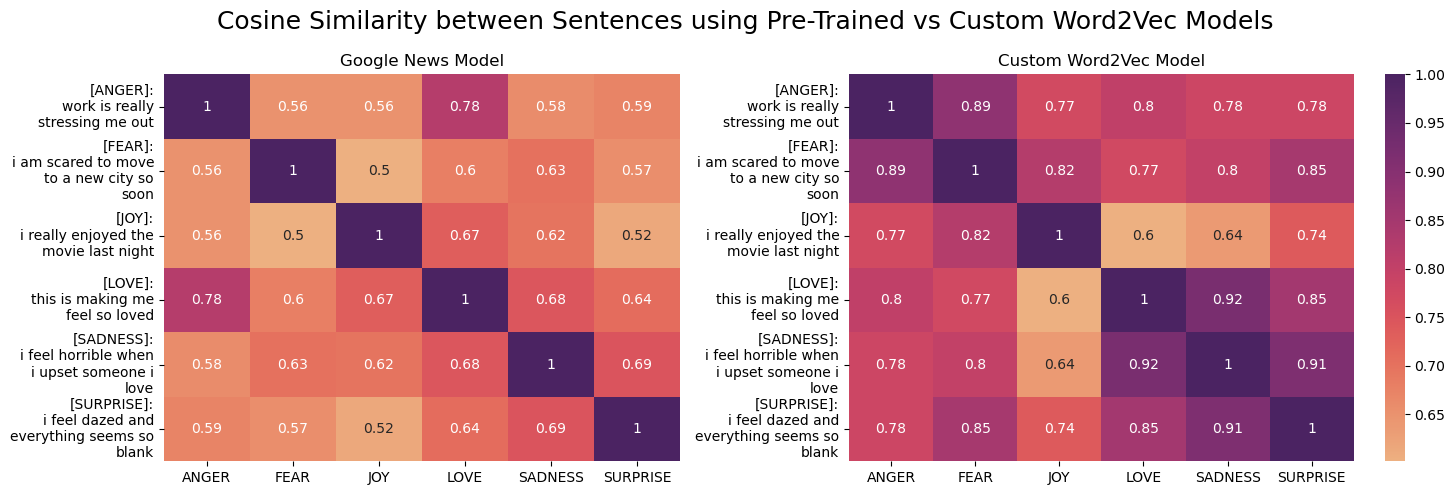

In [135]:
fig,axs = plt.subplots(figsize= (15,5), ncols= 2, width_ratios= [0.45, 0.55])

# re.replace(/((?:.*?\s){2}.*?)\s/g, '\\1\n')
xlabels_new = ["["+ ee.upper()+"]:\n"+'\n'.join(wrap(label, width=20)) for label,ee in zip(X_disp, emotions)]

test_goog = W2VEmbeddings(weights= 'idf', w2v_model= goog_wordvecs, max_len= 300).fit_transform(X_disp)
sns.heatmap(pd.DataFrame(cosine_similarity(test_goog), index = xlabels_new, columns= X_disp.index.str.upper()), annot= True, cbar= False,
            cmap= sns.color_palette("flare", as_cmap=True), ax= axs[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].set_title("Google News Model")

test_custom = W2VEmbeddings(weights= 'idf', w2v_model= model.wv, max_len= 300).fit_transform(X_disp)
sns.heatmap(pd.DataFrame(cosine_similarity(test_custom), index = xlabels_new, columns= X_disp.index.str.upper()), annot= True,
            cmap= sns.color_palette("flare", as_cmap=True), ax= axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].set_title("Custom Word2Vec Model");

plt.suptitle("Cosine Similarity between Sentences using Pre-Trained vs Custom Word2Vec Models", fontsize= 18)
plt.tight_layout();
fig.savefig("images/word2vec_similarity.png")



In [141]:
pipe_svm = Pipeline([
    ('w2v', W2VEmbeddings(weights= 'idf', w2v_model= goog_wordvecs, max_len= 300)),
    ('clf', SGDClassifier(loss= 'hinge', penalty= 'l2', max_iter= 100))
])
%time pipe_svm.fit(X_train, y_train)
%time y_pred = pipe_svm.predict(X_test)

print(f"SVM accuracy is: {accuracy_score(y_test, y_pred):0.2f}.\n")
print(classification_report(y_test, y_pred))

# # save SVC classifier
# with open('models/w2v_svc.pkl','wb') as f:
#     pickle.dump(pipe_svm,f)

AttributeError: Can't pickle local object 'W2VEmbeddings.fit.<locals>.<lambda>'

In [140]:
pipe_logreg = Pipeline([
    ('w2v', W2VEmbeddings(weights= 'idf', w2v_model= goog_wordvecs, max_len= 300)),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])
%time pipe_logreg.fit(X_train, y_train)
%time y_pred = pipe_logreg.predict(X_test)

print(f"Logistic Regression accuracy is: {accuracy_score(y_test, y_pred):0.2f}.\n")
print(classification_report(y_test, y_pred))

# # save log reg classifier
# with open('models/w2v_logreg.pkl','wb') as f:
#     pickle.dump(pipe_logreg,f)

AttributeError: Can't pickle local object 'W2VEmbeddings.fit.<locals>.<lambda>'

In [136]:
pipe_logreg_custom = Pipeline([
    ('w2v', W2VEmbeddings(weights= 'idf', w2v_model= model.wv, max_len= 300)),
    ('scaler', StandardScaler()),
    ('svc',OneVsRestClassifier(LogisticRegression()))
])
%time pipe_logreg_custom.fit(X_train, y_train)
%time y_pred_custom = pipe_logreg_custom.predict(X_test)

print(f"SVM accuracy is: {accuracy_score(y_test, y_pred_custom):0.2f}.\n")
print(classification_report(y_test, y_pred_custom))

Fit the IDF Model


c:\Users\garim\anaconda3\envs\github\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\garim\anaconda3\envs\github\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

CPU times: total: 14.8 s
Wall time: 53.2 s
CPU times: total: 14.2 s
Wall time: 56.2 s
SVM accuracy is: 0.58.

              precision    recall  f1-score   support

       anger       0.57      0.30      0.39     32390
        fear       0.56      0.29      0.38     27463
         joy       0.61      0.83      0.71     78418
        love       0.52      0.18      0.27     18992
     sadness       0.55      0.70      0.61     67437
    surprise       0.46      0.11      0.17      8233

    accuracy                           0.58    232933
   macro avg       0.54      0.40      0.42    232933
weighted avg       0.57      0.58      0.54    232933



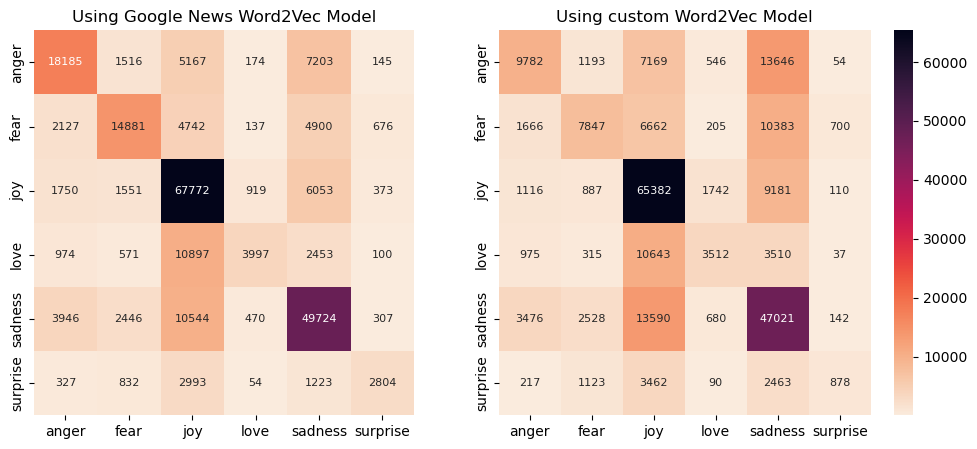

In [120]:
fig,axs = plt.subplots(figsize= (12,5), ncols= 2, width_ratios= [0.45, 0.55])

sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred), index= emotions, columns= emotions), annot= True, cbar= False,
            cmap= sns.color_palette("rocket_r", as_cmap=True), annot_kws={"fontsize":8}, fmt= 'g', ax= axs[0])
axs[0].set_title("Using Google News Word2Vec Model")

sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_custom), index= emotions, columns= emotions), annot= True, cbar= True,
            cmap= sns.color_palette("rocket_r", as_cmap=True), annot_kws={"fontsize":8}, fmt= 'g', ax= axs[1])
axs[1].set_title("Using custom Word2Vec Model");

# plt.tight_layout()

In [116]:
y_test_oe = label_binarize(y_test, classes= emotions)
y_pred_oe = pipe_logreg.predict_proba(X_test)

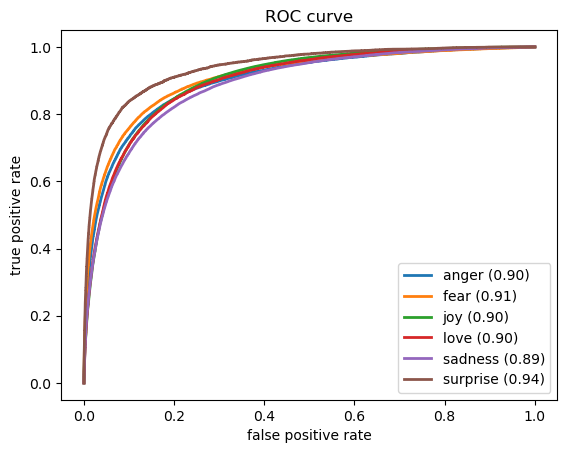

In [117]:
# roc curve
fpr = dict()
tpr = dict()

for i in range(len(emotions)):
    fpr[i], tpr[i], _ = roc_curve(y_test_oe[:, i],
                                  y_pred_oe[:, i])
    auc = roc_auc_score(y_test_oe[:, i],y_pred_oe[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label= f"{emotions[i]} ({auc:0.2f})")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()
